# <center>COVID-19 Forecasting for LA County </center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter1d
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA
import math
import datetime
import sklearn
import calendar
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ParameterGrid
from math import sqrt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading Data
df = pd.read_csv('LA_County_Covid19_cases.csv')
df=df[~df.date.isnull()]
df.date = pd.to_datetime(df.date)
df.set_index('date', inplace=True)
df.head()

,new_case,new_deaths,persons_tested,persons_positive,hospitalizations
date,,,,,
2020-03-01,25.0,0.0,NaN,NaN,NaN
2020-03-02,19.0,0.0,NaN,NaN,NaN
2020-03-03,13.0,0.0,NaN,NaN,NaN
2020-03-04,19.0,0.0,NaN,NaN,NaN
2020-03-05,33.0,0.0,NaN,NaN,NaN


# EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 184 entries, 2020-03-01 to 2020-08-31
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   new_case          184 non-null    float64
 1   new_deaths        184 non-null    float64
 2   persons_tested    175 non-null    float64
 3   persons_positive  175 non-null    float64
 4   hospitalizations  157 non-null    float64
dtypes: float64(5)
memory usage: 8.6 KB


In [4]:
# Interpolating missing values

df['hospitalizations'][0]=25.0
df['hospitalizations'].interpolate(method='linear',inplace=True)
df['persons_tested'][0]=25.0
df['persons_tested'].interpolate(method='linear',inplace=True)
df['persons_positive'][0]=0.0
df['persons_positive'].interpolate(method='linear',inplace=True)

In [5]:
df = np.floor(df)

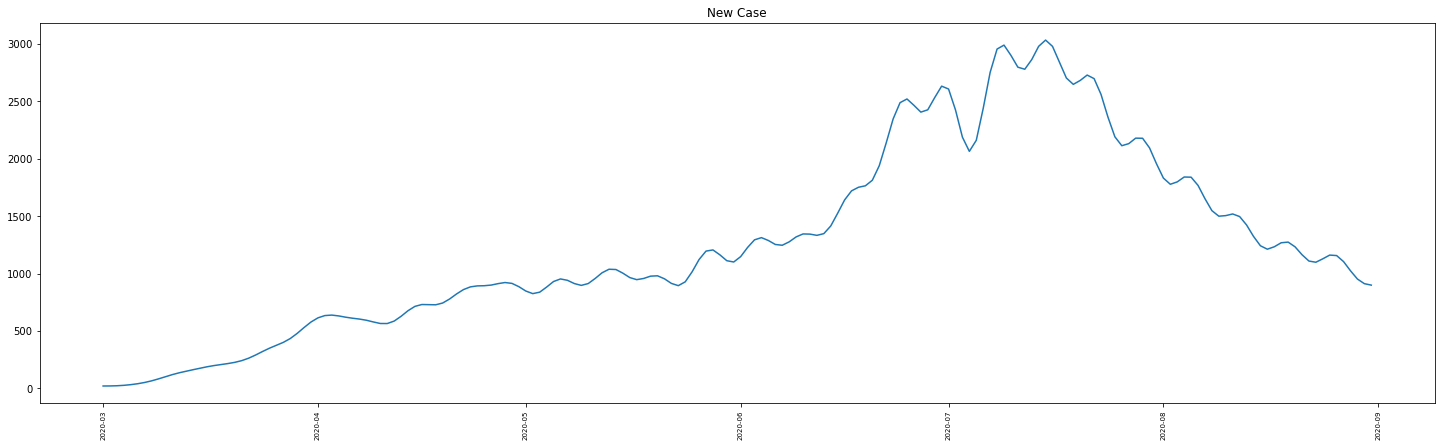

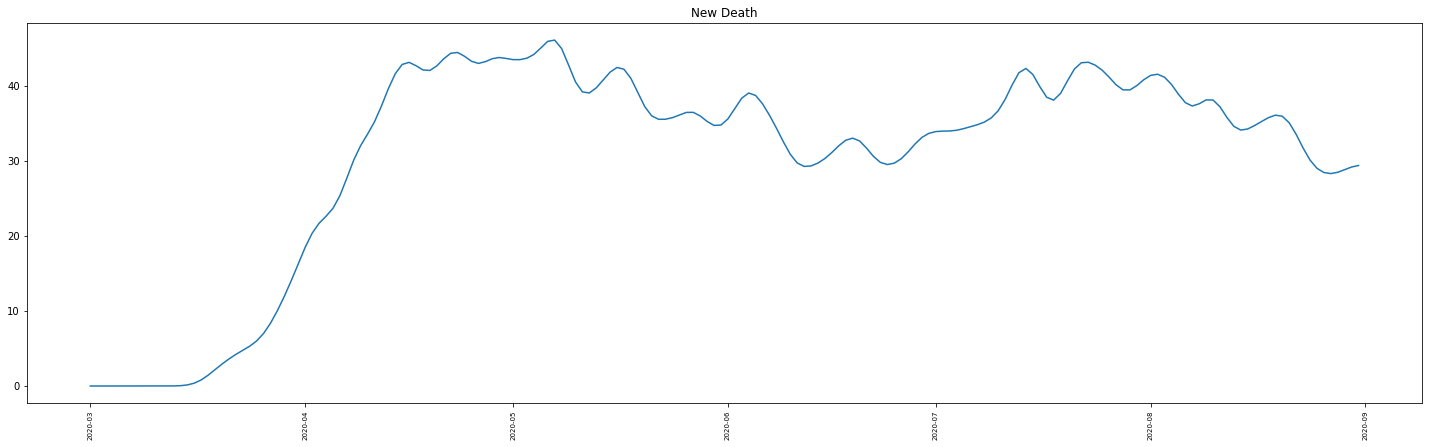

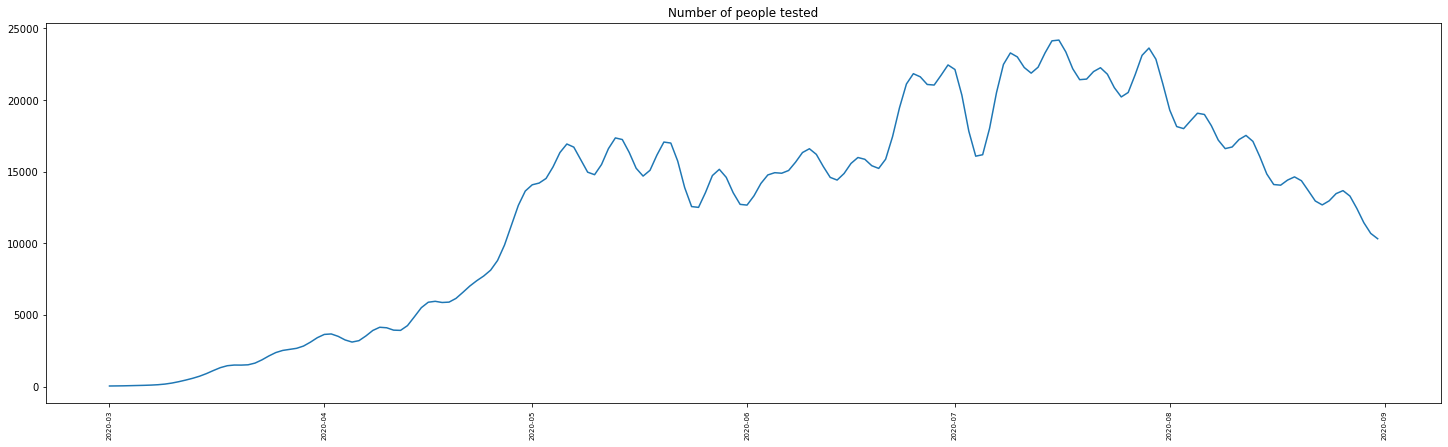

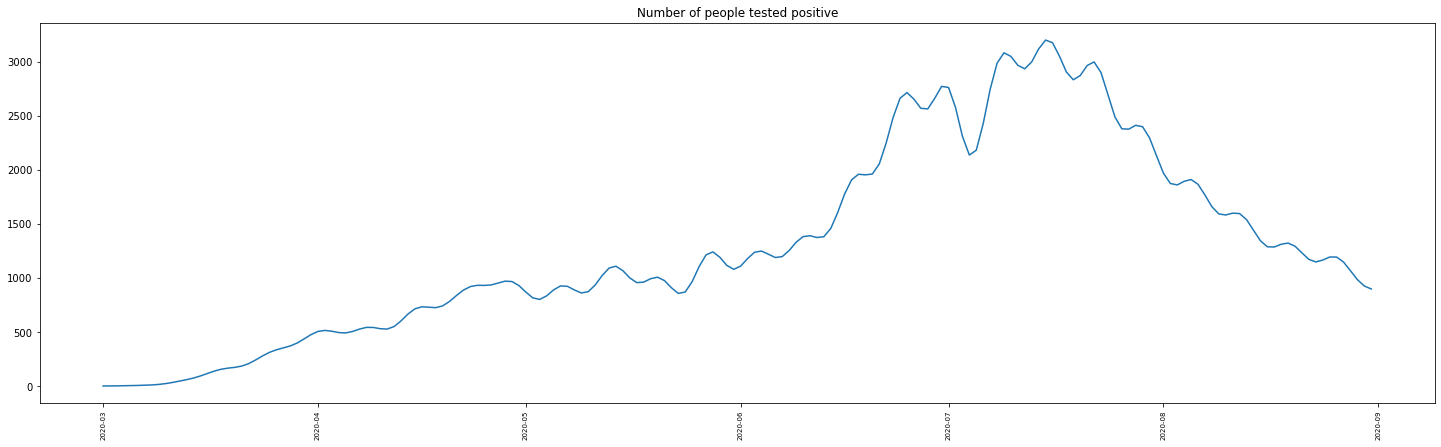

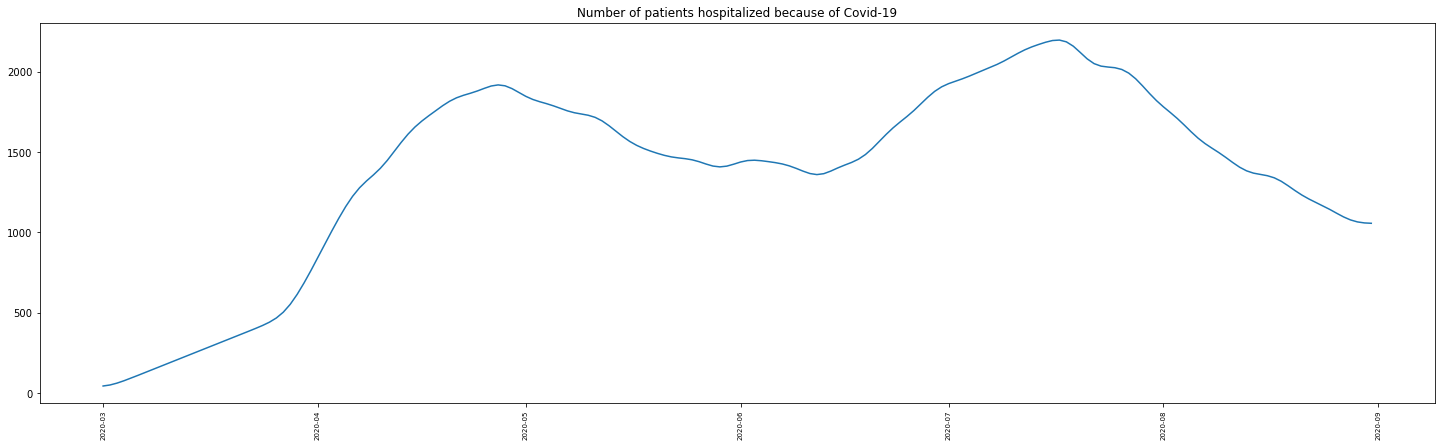

In [6]:
def EDA_plot(df, column_number, plot_title):
    plt.figure(figsize=(25,7))
    y_smoothed = gaussian_filter1d(df.iloc[:,column_number], sigma=2)
    plt.plot(df.index, y_smoothed)
    plt.title(plot_title)
    plt.xticks(rotation=90, fontsize=7)
    return plt.show()

EDA_plot(df, 0, 'New Case')
EDA_plot(df, 1, 'New Death')
EDA_plot(df, 2, 'Number of people tested')
EDA_plot(df, 3, 'Number of people tested positive')
EDA_plot(df, 4, 'Number of patients hospitalized because of Covid-19')

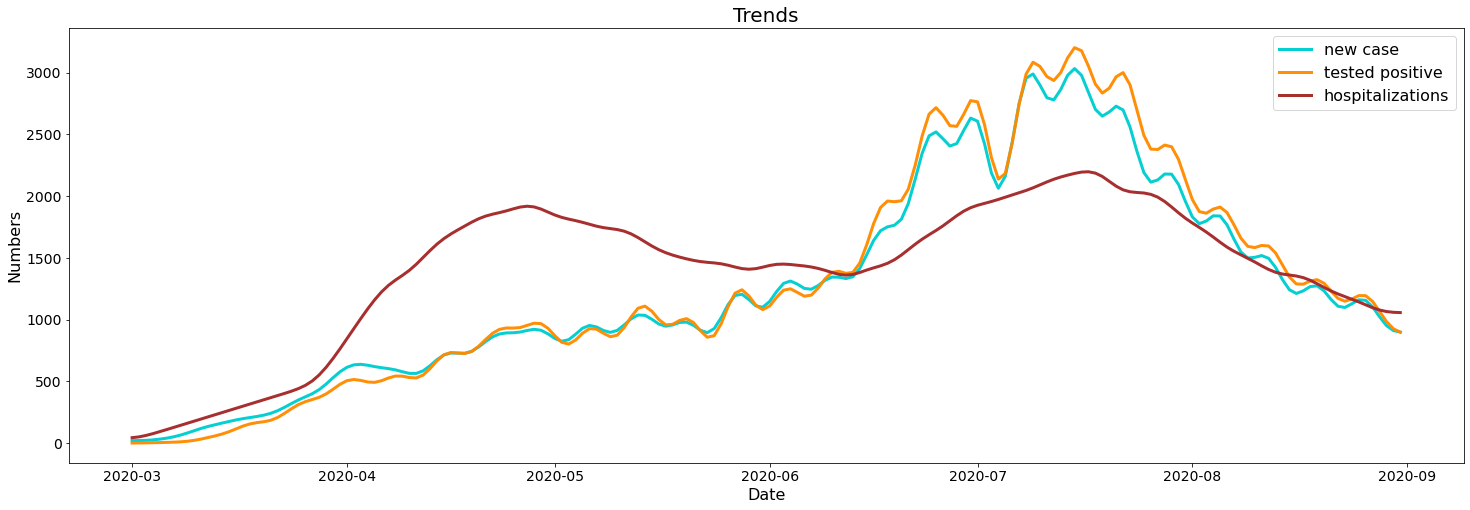

In [7]:
plt.figure(figsize=(25,8))
y_smoothed1 = gaussian_filter1d(df.iloc[:,0], sigma=2)
y_smoothed2 = gaussian_filter1d(df.iloc[:,3], sigma=2)
y_smoothed3 = gaussian_filter1d(df.iloc[:,4], sigma=2)

plt.plot(df.index, y_smoothed1, label='new case',lw=3,color='darkturquoise',alpha = 7)
plt.plot(df.index, y_smoothed2, label='tested positive',lw=3,color='darkorange',alpha = 7)
plt.plot(df.index, y_smoothed3, label='hospitalizations',lw=3,color='brown',alpha = 7)
plt.title('Trends',fontsize = 20)
plt.xlabel('Date',fontsize = 16)
plt.ylabel('Numbers', fontsize = 16)
plt.xticks(fontsize =14)
plt.yticks(fontsize =14)
plt.legend(fontsize = 16)
plt.show()

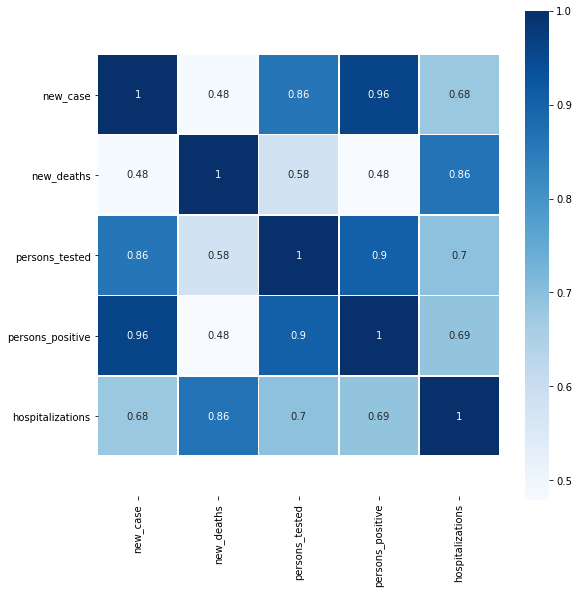

In [8]:
corrMatrix = df.corr()
plt.figure(figsize=(9,9))
ax = sns.heatmap(corrMatrix, annot=True, linewidths=.5, square = True, cmap = 'Blues')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + .5, top - .5)
plt.show()

In [9]:
df['day of week'] = df.index.day_name()
day_week_df = df.groupby('day of week').mean()
day_week_df = day_week_df.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

Text(0.5, 1.0, 'Hospitalizations')

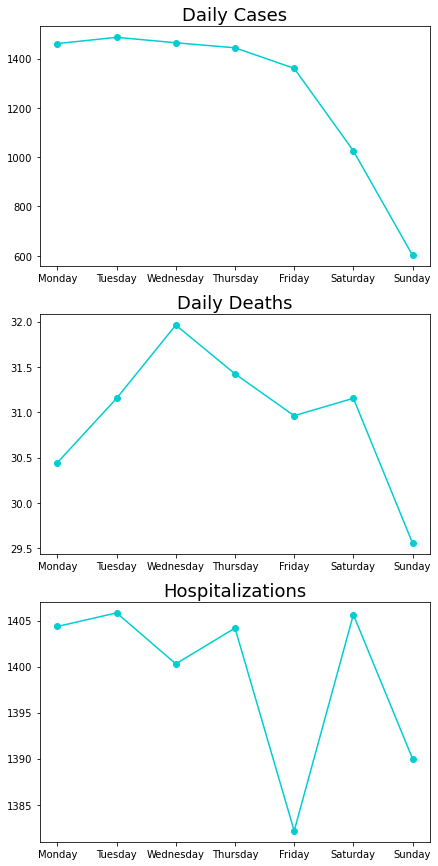

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (7,15))

# fig.suptitle('Horizontally stacked subplots')
ax1.plot(day_week_df.index, day_week_df['new_case'],color='darkturquoise',marker='o')
ax1.set_title('Daily Cases',fontsize = 18)
ax2.plot(day_week_df.index, day_week_df['new_deaths'],color='darkturquoise',marker='o')
ax2.set_title('Daily Deaths',fontsize = 18)
ax3.plot(day_week_df.index, day_week_df['hospitalizations'],color='darkturquoise',marker='o')
ax3.set_title('Hospitalizations',fontsize = 18)

# Forecasting New Cases

### Autoregressive Model (AR)

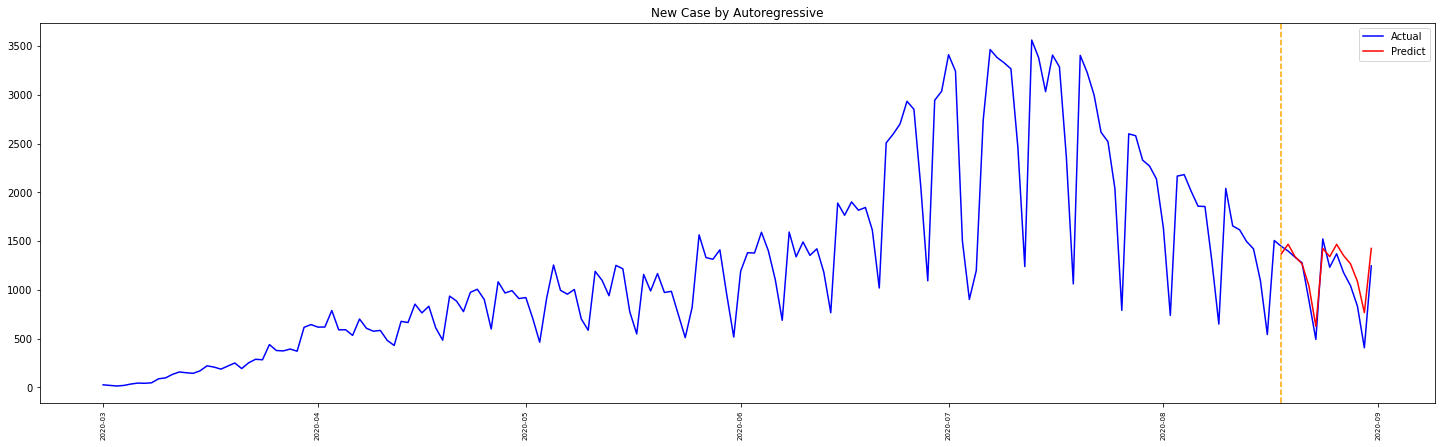

RMSE: 166.76994852544962


In [11]:
# AutoRegressvie - New Case

X = list(df.iloc[:,0])
train, test = X[0:len(X)-14], X[len(X)-14:]
model = AutoReg(train, lags=10, trend='c') # 19 has best
model_fit = model.fit()
prediction = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

df_new = pd.DataFrame({'date': list(df.index), 'X': X, 'Train_and_Pred': [None] * 170 + list(prediction)})
# plot results
plt.figure(figsize=(25,7))
plt.plot(df_new.iloc[:,0], df_new.iloc[:,1], label = 'Actual', color='blue')
plt.plot(df_new.iloc[:,0], df_new.iloc[:,2], label = 'Predict', color='red')
plt.title("New Case by Autoregressive")
plt.xticks(rotation=90, fontsize=7)
plt.axvline(x=datetime.datetime(2020,8,18), color='orange', linestyle='--')
plt.legend()
plt.show()

mse = sklearn.metrics.mean_squared_error(test, prediction)
rmse_AR = math.sqrt(mse)
print("RMSE:",rmse_AR)

### Moving Average (MA) model

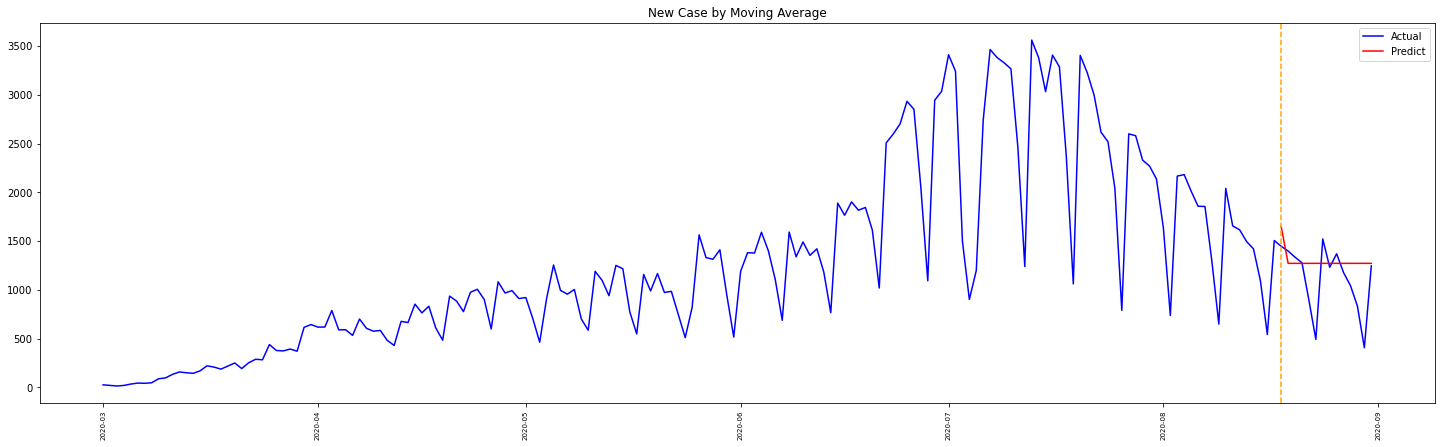

RMSE: 367.53067730467023


In [12]:
# Moving Average - New Case

# X = list(df.iloc[:,0])
train, test = df.iloc[0:len(df)-14, 0],df.iloc[len(df)-14:, 0]

model = ARMA(train, order=(0, 1), freq  = "D")
model_fit = model.fit(disp=False)
prediction = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

df_new = pd.DataFrame({'date': list(df.index), 'X': X, 'Train_and_Pred': [None] * 170 + list(prediction)})
plt.figure(figsize=(25,7))
plt.plot(df_new.iloc[:,0], df_new.iloc[:,1], label = 'Actual', color='blue')
plt.plot(df_new.iloc[:,0], df_new.iloc[:,2], label = 'Predict', color='red')
plt.title("New Case by Moving Average")
plt.xticks(rotation=90, fontsize=7)
plt.axvline(x=datetime.datetime(2020,8,18), color='orange', linestyle='--')
plt.legend()
plt.show()

mse = sklearn.metrics.mean_squared_error(test, prediction)
rmse_MA = math.sqrt(mse)
print("RMSE:",rmse_MA)

### Autoregressive Moving Average (ARMA)

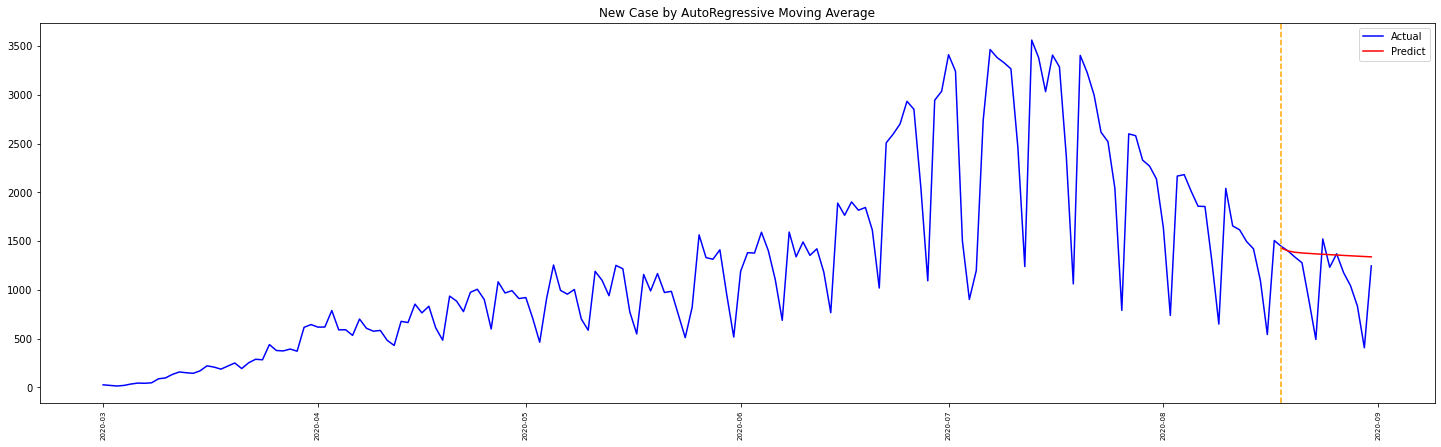

RMSE: 407.7149001577934


In [13]:
# import warnings
# warnings.filterwarnings("ignore")

# X = list(df.iloc[:,0])
train, test = df.iloc[0:len(df)-14, 0],df.iloc[len(df)-14:, 0]


model = ARMA(train, order=(2, 1), freq="D")
model_fit = model.fit(disp=False)
prediction = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

df_new = pd.DataFrame({'date': list(df.index), 'X': X, 'Train_and_Pred': [None] * 170 + list(prediction)})
plt.figure(figsize=(25,7))
plt.plot(df_new.iloc[:,0], df_new.iloc[:,1], label = 'Actual', color='blue')
plt.plot(df_new.iloc[:,0], df_new.iloc[:,2], label = 'Predict', color='red')
plt.title("New Case by AutoRegressive Moving Average")
plt.xticks(rotation=90, fontsize=7)
plt.axvline(x=datetime.datetime(2020,8,18), color='orange', linestyle='--')
plt.legend()
plt.show()

mse = sklearn.metrics.mean_squared_error(test, prediction)
rmse_ARMA = math.sqrt(mse)
print("RMSE:",rmse_ARMA)

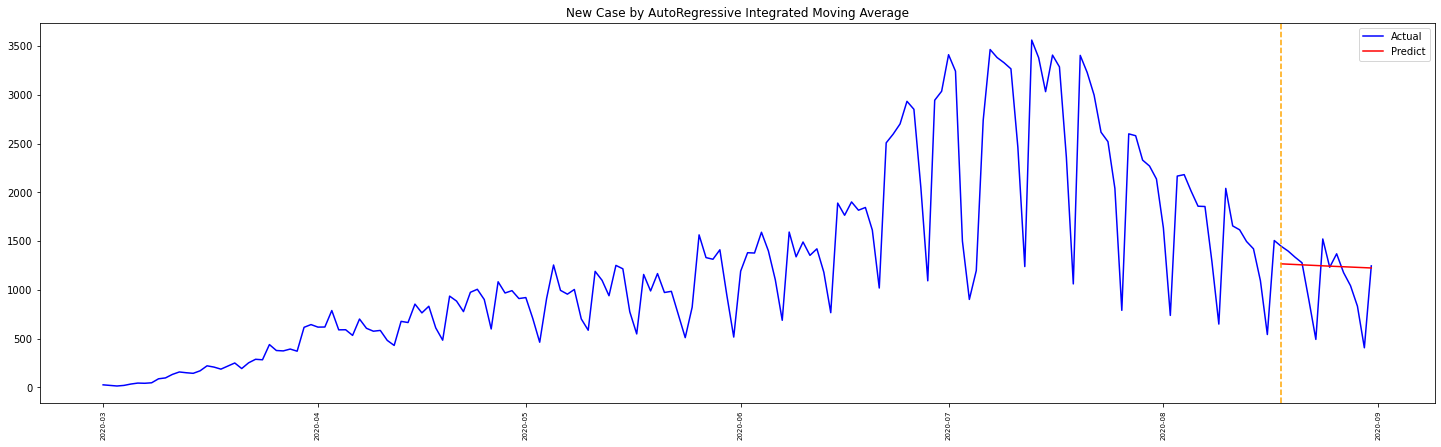

RMSE: 351.2519806266281


In [14]:
# Autoregressive Integrated Moving Average (ARIMA)

# X = list(df.iloc[:,0])
train, test = df.iloc[0:len(df)-14, 0],df.iloc[len(df)-14:, 0]

model = ARMA(train, order=(1,1,1), freq='D')
model_fit = model.fit(disp = False)
prediction = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

df_new = pd.DataFrame({'date': list(df.index), 
                      'X': X, 
                      'Train_and_Pred': [None] * 170 + list(prediction)})
# plot results
plt.figure(figsize=(25,7))
plt.plot(df_new.iloc[:,0], df_new.iloc[:,1], label = 'Actual', color='blue')
plt.plot(df_new.iloc[:,0], df_new.iloc[:,2], label = 'Predict', color='red')
plt.title("New Case by AutoRegressive Integrated Moving Average")
plt.xticks(rotation=90, fontsize=7)
plt.axvline(x=datetime.datetime(2020,8,18), color='orange', linestyle='--')
plt.legend()
plt.show()

mse = sklearn.metrics.mean_squared_error(test, prediction)
rmse_ARIMA = math.sqrt(mse)
print("RMSE:",rmse_ARIMA)

In [15]:
print(rmse_AR)
print(rmse_MA)
print(rmse_ARMA)
print(rmse_ARIMA)

166.76994852544962
367.53067730467023
407.7149001577934
351.2519806266281


In [16]:
names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df = df.join(pd.get_dummies(df.index.day_name())
                .set_index(df.index).reindex(columns=names, fill_value=0))

In [17]:
#find optimal value for past
inputs = df.persons_positive
outputs = df.new_case
def calculate_lookback(past):
    s = (len(inputs) , past  * 2 + len(names))
    betterinputs = np.zeros(s)
    betteroutputs = np.zeros(len(inputs))
    for i in range(len(inputs) - past):
      temp = np.zeros(past * 2)
      temp[0 : past] = inputs[i : i+ past]
      temp[past:] = outputs[i : i + past]
      betterinputs[i] = np.append(temp,(np.asarray(df[names].iloc[i+past])))
      betteroutputs[i] = outputs[i+past] #when predicting cases
      #use betteroutputs[i] = outputs[i+past] when predicting deaths
    betterinputs = betterinputs[0:len(df) - past]
    betteroutputs = betteroutputs[0:len(df) - past]
    split = int(0.92*len(betterinputs))
    X_train, X_test, y_train, y_test = betterinputs[:split], betterinputs[split:], betteroutputs[:split], betteroutputs[split:]
    model = RidgeCV(cv=2)
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    return(r2_score(y_test,predict))

for i in range(3,14):
    print('Num of days ', i, ' will achieve r-squared of ', calculate_lookback(i))
    
    

Num of days  3  will achieve r-squared of  0.6843841712064621
Num of days  4  will achieve r-squared of  0.6789691229422482
Num of days  5  will achieve r-squared of  0.7250675003258324
Num of days  6  will achieve r-squared of  0.657476234228282
Num of days  7  will achieve r-squared of  0.7744448345727521
Num of days  8  will achieve r-squared of  0.8369879606849403
Num of days  9  will achieve r-squared of  0.8515111719509663
Num of days  10  will achieve r-squared of  0.8768783438250707
Num of days  11  will achieve r-squared of  0.8675952046661227
Num of days  12  will achieve r-squared of  0.8732443821539694
Num of days  13  will achieve r-squared of  0.8703440888734099


In [18]:
past = 10
s = (len(inputs) , past  * 2 + len(names))
betterinputs = np.zeros(s)
betteroutputs = np.zeros(len(inputs))
for i in range(len(inputs) - past):
  temp = np.zeros(past * 2)
  temp[0 : past] = inputs[i : i+ past]
  temp[past:] = outputs[i : i + past]
  betterinputs[i] = np.append(temp,(np.asarray(df[names].iloc[i+past])))
  betteroutputs[i] = outputs[i+past] #when predicting cases
  #use betteroutputs[i] = outputs[i+past] when predicting deaths
betterinputs = betterinputs[0:len(df) - past]
betteroutputs = betteroutputs[0:len(df) - past]

In [19]:
split = int(0.92*len(betterinputs))
X_train, X_test, y_train, y_test = betterinputs[:split], betterinputs[split:], betteroutputs[:split], betteroutputs[split:]

from sklearn.linear_model import RidgeCV
model = RidgeCV(cv=2)
model.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=2)

99.81788300649319


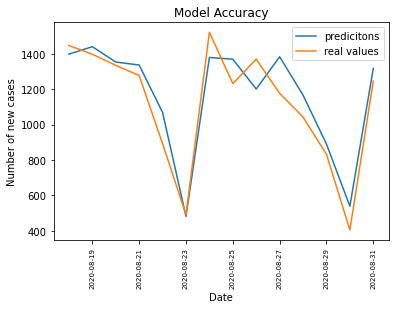

In [20]:
# nsamples, nx, ny = X_test.shape
# X_test_reshape = X_test.reshape((nsamples,nx*ny))
predict = model.predict(X_test)
print("{}".format(np.linalg.norm(predict - y_test, 1)/len(y_test)))
plt.title("Model Accuracy")
plt.plot( df.index[len(df)-len(X_test):] ,predict, label = "predicitons")
plt.plot( df.index[len(df)-len(X_test):], y_test,  label = "real values")
plt.xlabel("Date")
plt.xticks(rotation=90, fontsize=7)
plt.ylabel("Number of new cases")
plt.legend()

In [21]:
print('R-squared: ',r2_score(y_test,predict))
print('RMSE: ',np.sqrt(mean_squared_error(y_test,predict)))

R-squared:  0.8768783438250707
RMSE:  116.94810224184978


# Forecasting Hospitalizations

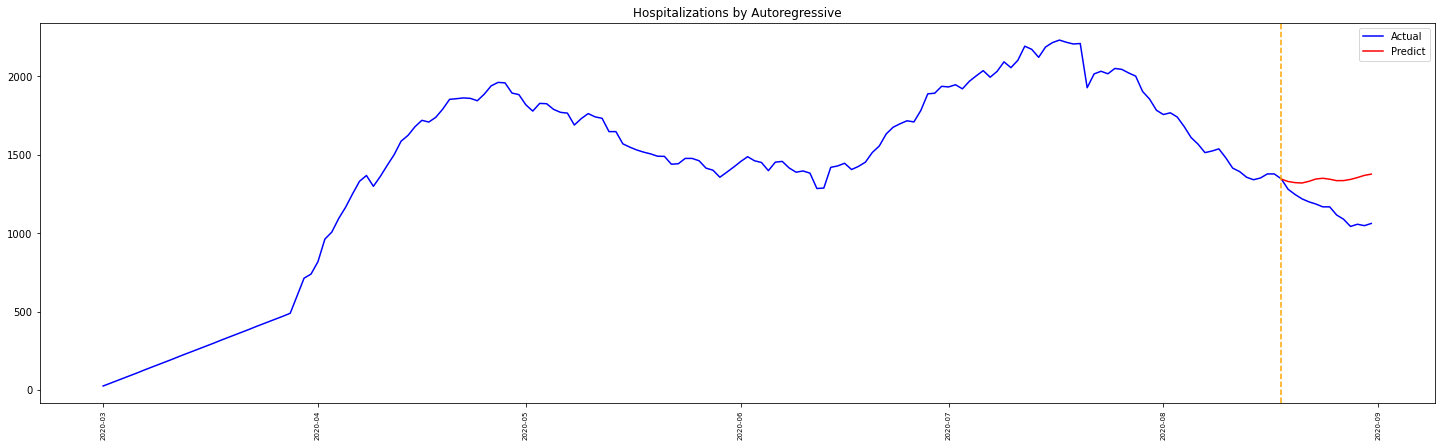

RMSE: 209.5361355261879


In [22]:
# AutoRegressvie - New Case

X = list(df.iloc[:,4])
train, test = X[0:len(X)-14], X[len(X)-14:]
model = AutoReg(train, lags=list(range(1,15)), trend='c') # 19 has best
model_fit = model.fit()
prediction = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

df_new = pd.DataFrame({'date': list(df.index), 'X': X, 'Train_and_Pred': [None] * 170 + list(prediction)})
# plot results
plt.figure(figsize=(25,7))
plt.plot(df_new.iloc[:,0], df_new.iloc[:,1], label = 'Actual', color='blue')
plt.plot(df_new.iloc[:,0], df_new.iloc[:,2], label = 'Predict', color='red')
plt.title("Hospitalizations by Autoregressive")
plt.xticks(rotation=90, fontsize=7)
plt.axvline(x=datetime.datetime(2020,8,18), color='orange', linestyle='--')
plt.legend()
plt.show()

mse = sklearn.metrics.mean_squared_error(test, prediction)
rmse_AR = math.sqrt(mse)
print("RMSE:",rmse_AR)

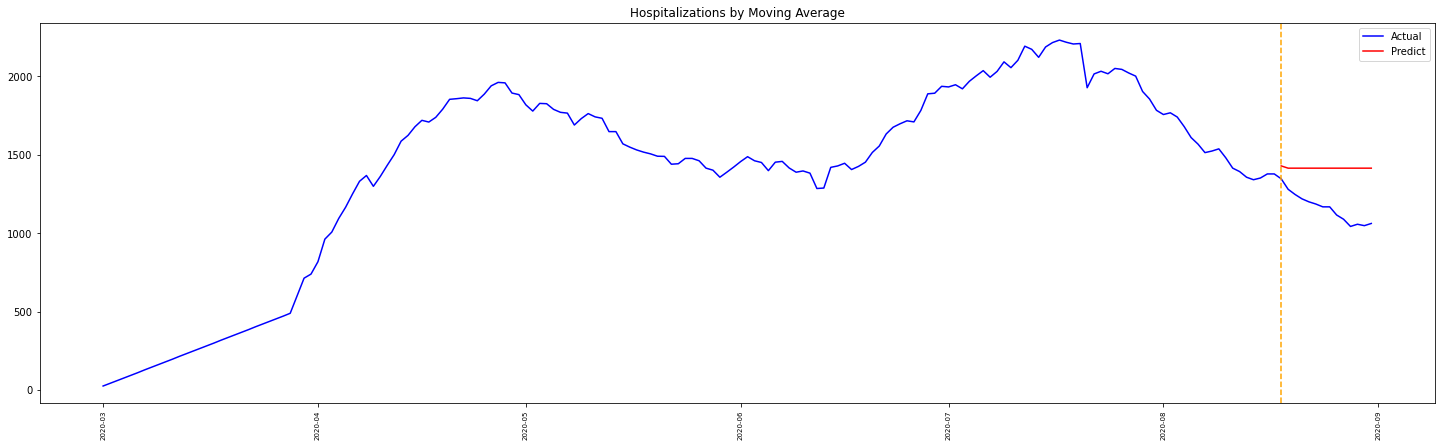

RMSE: 271.55097096474157


In [23]:
# Moving Average - New Case

# X = list(df.iloc[:,0])
train, test = df.iloc[0:len(df)-14, 4],df.iloc[len(df)-14:, 4]

model = ARMA(train, order=(0, 1), freq  = "D")
model_fit = model.fit(disp=False)
prediction = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

df_new = pd.DataFrame({'date': list(df.index), 'X': df.iloc[:,4], 'Train_and_Pred': [None] * 170 + list(prediction)})
plt.figure(figsize=(25,7))
plt.plot(df_new.iloc[:,0], df_new.iloc[:,1], label = 'Actual', color='blue')
plt.plot(df_new.iloc[:,0], df_new.iloc[:,2], label = 'Predict', color='red')
plt.title("Hospitalizations by Moving Average")
plt.xticks(rotation=90, fontsize=7)
plt.axvline(x=datetime.datetime(2020,8,18), color='orange', linestyle='--')
plt.legend()
plt.show()

mse = sklearn.metrics.mean_squared_error(test, prediction)
rmse_MA = math.sqrt(mse)
print("RMSE:",rmse_MA)

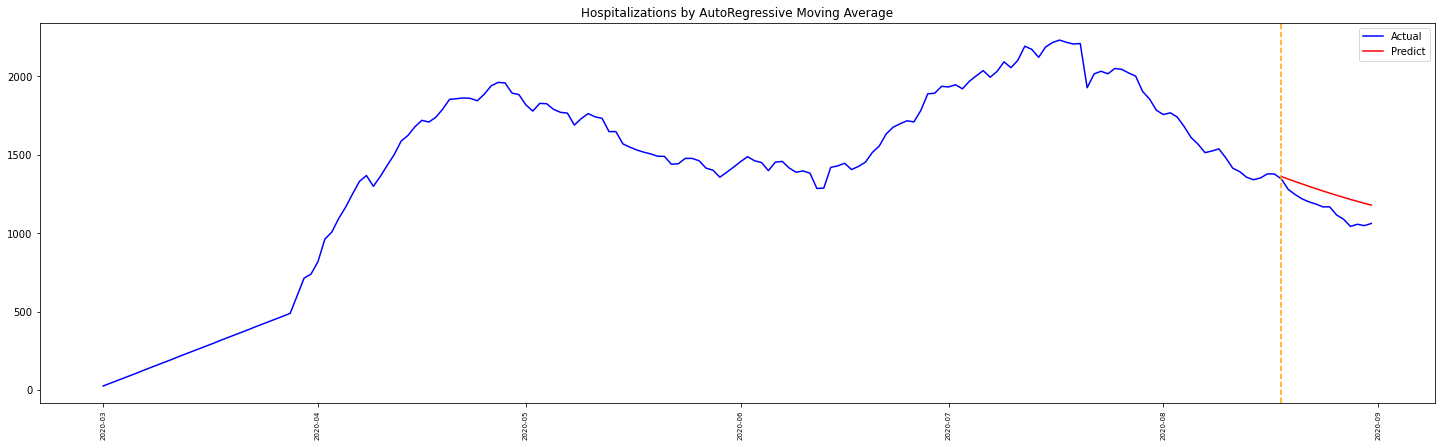

RMSE: 112.76303657268868


In [24]:
# Autoregressive Moving Average (ARMA)

# import warnings
# warnings.filterwarnings("ignore")

train, test = df.iloc[0:len(df)-14, 4],df.iloc[len(df)-14:, 4]

model = ARMA(train, order=(2, 1))
model_fit = model.fit(disp=False)
prediction = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

df_new = pd.DataFrame({'date': list(df.index), 'X': df.iloc[:,4], 'Train_and_Pred': [None] * 170 + list(prediction)})
plt.figure(figsize=(25,7))
plt.plot(df_new.iloc[:,0], df_new.iloc[:,1], label = 'Actual', color='blue')
plt.plot(df_new.iloc[:,0], df_new.iloc[:,2], label = 'Predict', color='red')
plt.title("Hospitalizations by AutoRegressive Moving Average")
plt.xticks(rotation=90, fontsize=7)
plt.axvline(x=datetime.datetime(2020,8,18), color='orange', linestyle='--')
plt.legend()
plt.show()

mse = sklearn.metrics.mean_squared_error(test, prediction)
rmse_ARMA = math.sqrt(mse)
print("RMSE:",rmse_ARMA)

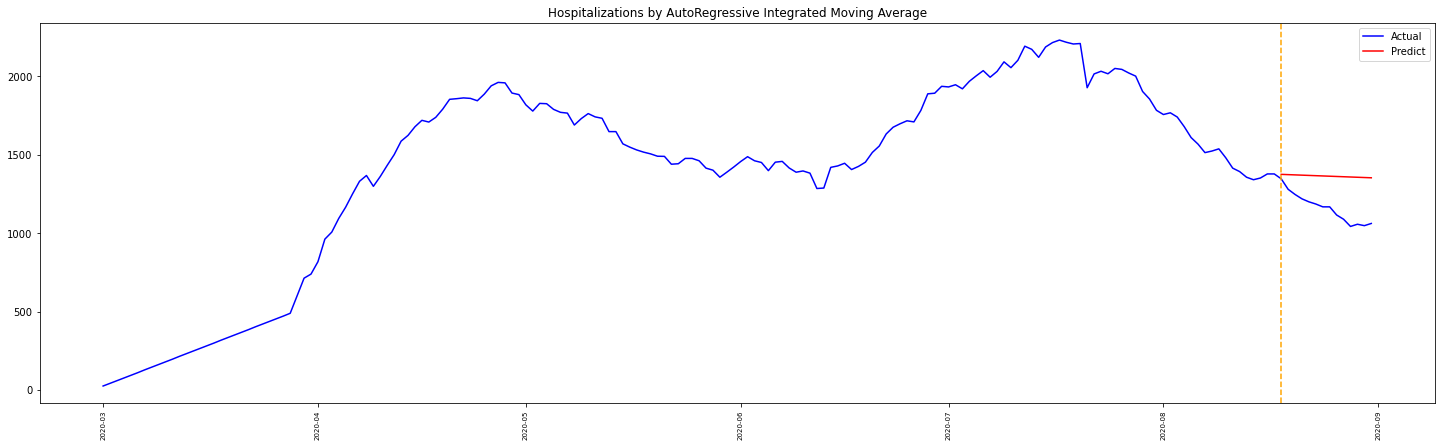

RMSE: 221.71846828500315


In [25]:
# Autoregressive Integrated Moving Average (ARIMA)

train, test = df.iloc[0:len(df)-14, 4],df.iloc[len(df)-14:, 4]

model = ARMA(train, order=(1,1,1))
model_fit = model.fit(disp=False)
prediction = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

df_new = pd.DataFrame({'date': df.index, 
                      'X': df.iloc[:,4], 
                      'Train_and_Pred': [None] * 170 + list(prediction)})
# plot results
plt.figure(figsize=(25,7))
plt.plot(df_new.iloc[:,0], df_new.iloc[:,1], label = 'Actual', color='blue')
plt.plot(df_new.iloc[:,0], df_new.iloc[:,2], label = 'Predict', color='red')
plt.title("Hospitalizations by AutoRegressive Integrated Moving Average")
plt.xticks(rotation=90, fontsize=7)
plt.axvline(x=datetime.datetime(2020,8,18), color='orange', linestyle='--')
plt.legend()
plt.show()

mse = sklearn.metrics.mean_squared_error(test, prediction)
rmse_ARIMA = math.sqrt(mse)
print("RMSE:",rmse_ARIMA)

In [26]:
print(rmse_AR)
print(rmse_MA)
print(rmse_ARMA)
print(rmse_ARIMA)

209.5361355261879
271.55097096474157
112.76303657268868
221.71846828500315


In [27]:
#Hyperparameter tuning - find optimal past value
inputs = df.new_case
outputs = df.hospitalizations
def calculate_lookback(past):
    s = (len(inputs) , past  * 2 + len(names))
    betterinputs = np.zeros(s)
    betteroutputs = np.zeros(len(inputs))
    for i in range(len(inputs) - past):
      temp = np.zeros(past * 2)
      temp[0 : past] = inputs[i : i+ past]
      temp[past:] = outputs[i : i + past]
      betterinputs[i] = np.append(temp,(np.asarray(df[names].iloc[i+past])))
      betteroutputs[i] = outputs[i+past] #when predicting cases
      #use betteroutputs[i] = outputs[i+past] when predicting deaths
    betterinputs = betterinputs[0:len(df) - past]
    betteroutputs = betteroutputs[0:len(df) - past]
    split = int(0.92*len(betterinputs))
    X_train, X_test, y_train, y_test = betterinputs[:split], betterinputs[split:], betteroutputs[:split], betteroutputs[split:]
    model = RidgeCV(cv=2)
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    return(r2_score(y_test,predict))

for i in range(3,14):
    print('Num of days ', i, ' will achieve r-squared of ', calculate_lookback(i))


Num of days  3  will achieve r-squared of  0.9032064003207753
Num of days  4  will achieve r-squared of  0.9222483643599108
Num of days  5  will achieve r-squared of  0.9285066651655884
Num of days  6  will achieve r-squared of  0.9242304377195514
Num of days  7  will achieve r-squared of  0.922835944458751
Num of days  8  will achieve r-squared of  0.9215695479896533
Num of days  9  will achieve r-squared of  0.8956805464052172
Num of days  10  will achieve r-squared of  0.8970389314840794
Num of days  11  will achieve r-squared of  0.8886404968934256
Num of days  12  will achieve r-squared of  0.8887609409106517
Num of days  13  will achieve r-squared of  0.877277628746675


In [28]:
past = 7
s = (len(inputs) , past  * 2 + len(names))
betterinputs = np.zeros(s)
betteroutputs = np.zeros(len(inputs))
for i in range(len(inputs) - past):
  temp = np.zeros(past * 2)
  temp[0 : past] = inputs[i : i+ past]
  temp[past:] = outputs[i : i + past]
  betterinputs[i] = np.append(temp,(np.asarray(df[names].iloc[i+past])))
  betteroutputs[i] = outputs[i+past] #when predicting cases
  #use betteroutputs[i] = outputs[i+past] when predicting deaths
betterinputs = betterinputs[0:len(df) - past]
betteroutputs = betteroutputs[0:len(df) - past]


In [29]:
split = int(0.92*len(betterinputs))
X_train, X_test, y_train, y_test = betterinputs[:split], betterinputs[split:], betteroutputs[:split], betteroutputs[split:]

from sklearn.linear_model import RidgeCV
model = RidgeCV(cv=2)
model.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=2)

23.323339040134442


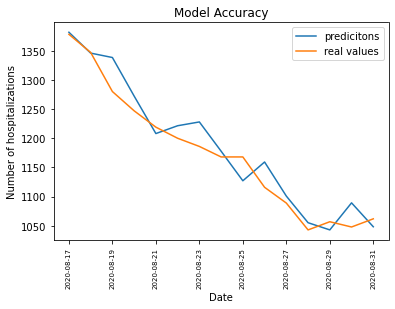

In [30]:
predict = model.predict(X_test)
print("{}".format(np.linalg.norm(predict - y_test, 1)/len(y_test)))
plt.title("Model Accuracy")
plt.plot( df.index[len(df)-len(X_test):] ,predict, label = "predicitons")
plt.plot( df.index[len(df)-len(X_test):], y_test,  label = "real values")
plt.xlabel("Date")
plt.xticks(rotation=90, fontsize=7)
plt.ylabel("Number of hospitalizations")
plt.legend()

In [31]:
print('R-squared: ',r2_score(y_test,predict))
print('RMSE: ',np.sqrt(mean_squared_error(y_test,predict)))

R-squared:  0.922835944458751
RMSE:  28.76872800192124


# EDA Part 2

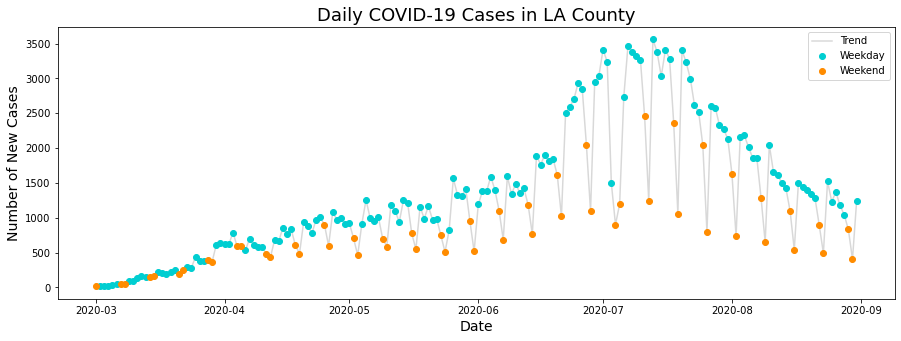

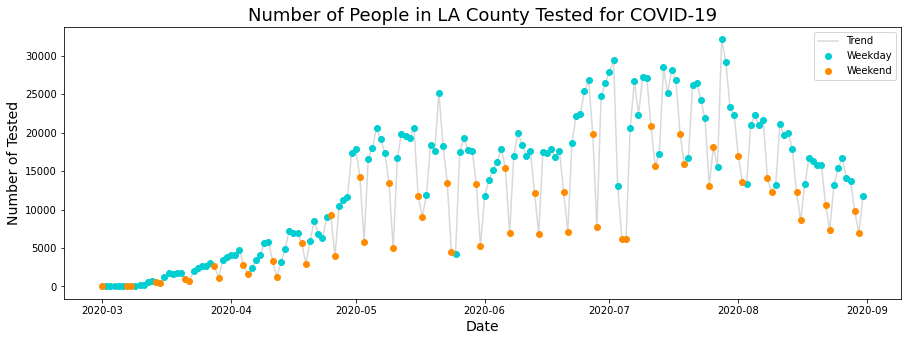

In [32]:
# clean and tranform data
df = pd.read_csv('LA_County_Covid19_cases.csv')
df = df[df['date'].notnull()]
df = df.fillna(0)
df['date'] = pd.to_datetime(df['date'])
df = df.astype({'new_case':'int32', 'new_deaths': 'int32', 'persons_tested': 'int32', 
            'persons_positive':'int32','hospitalizations':'int32'})

def EDA_plot_s(y, y_label,title):
    weekend = df['date'].dt.dayofweek >= 5
    f, ax = plt.subplots(1)
    f.set_figheight(5)
    f.set_figwidth(15)
    plt.plot('date',y,data=df,color='grey',alpha=0.3,label='Trend')
    plt.plot( 'date', y, data=df[-weekend],marker='o',linestyle = 'None',color='darkturquoise',label='Weekday')
    plt.plot('date',y,data=df[weekend],marker='o',linestyle = 'None',color='darkorange',label='Weekend')
    plt.ylabel(y_label,fontsize=14)
    plt.xlabel('Date',fontsize=14)
    plt.title(title,fontsize=18)
    plt.legend()
    plt.show()

EDA_plot_s('new_case',"Number of New Cases",'Daily COVID-19 Cases in LA County')
EDA_plot_s('persons_tested','Number of Tested','Number of People in LA County Tested for COVID-19')


# Forecasting Prophet

In [88]:
#pip install fbprophet
import fbprophet
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ParameterGrid
from math import sqrt

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [96]:
# return parameters with mae and rmse
def param(train_data,test_data,gird):
    model_parameters = pd.DataFrame(columns = ['MAE','RMSE','R_Square','Parameters'])
    for p in grid:
        test = pd.DataFrame()
        train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                             holidays_prior_scale = p['holidays_prior_scale'],
                             n_changepoints = p['n_changepoints'],
                             seasonality_mode = p['seasonality_mode'],
                             weekly_seasonality=True,
                             interval_width=0.95)

        train_model.fit(train_data)
        train_forecast = train_model.make_future_dataframe(periods=14, freq='D',include_history = False)
        train_forecast = train_model.predict(train_forecast)
        pred=train_forecast[['ds','yhat']]
        Actual = test_data
        # calculate MAE, RMSE between expected and predicted values for december
        mae = mean_absolute_error(test_data['y'], pred['yhat'])
        rmse = sqrt(mean_squared_error(test_data['y'], pred['yhat']))
        r_square = r2_score(test_data['y'], pred['yhat'])
        model_parameters = model_parameters.append({'MAE':mae,'RMSE':rmse,'R_Square':r_square,'Parameters':p},ignore_index=True)
        
    parameters = model_parameters.sort_values(by=['RMSE'])
    parameters = parameters.reset_index(drop=True)  
    return parameters

In [97]:
# set last 14 days as test set, the rest as train set
# new case
split = df['date'] < '2020-08-18'
new_case_train = df[split][['date','new_case']]
new_case_train.columns = ['ds', 'y']
new_case_test = df[-split][['date','new_case']]
new_case_test.columns = ['ds', 'y']

# hyperparameters tuning 
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.05,0.1,0.15,0.175,0.2,0.25],
              'holidays_prior_scale':[0.2,0.25,0.3,0.35,0.4],
              'n_changepoints' : [50,75,100,125,150,200]
            }
grid = ParameterGrid(params_grid)
parameters = param(new_case_train, new_case_test, grid)
parameters.head()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

,MAE,RMSE,R_Square,Parameters
0,104.382469,111.707344,0.887666,"{'changepoint_prior_scale': 0.15, 'holidays_pr..."
1,104.382469,111.707344,0.887666,"{'changepoint_prior_scale': 0.15, 'holidays_pr..."
2,104.382469,111.707344,0.887666,"{'changepoint_prior_scale': 0.15, 'holidays_pr..."
3,104.382469,111.707344,0.887666,"{'changepoint_prior_scale': 0.15, 'holidays_pr..."
4,104.382469,111.707344,0.887666,"{'changepoint_prior_scale': 0.15, 'holidays_pr..."


In [98]:
# best parameters with MAE = 104 and RMSE = 111.7
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.15,
 'holidays_prior_scale': 0.4,
 'n_changepoints': 100,
 'seasonality_mode': 'additive'}

In [99]:
final_model = Prophet(
                      changepoint_prior_scale= 0.15,
                      holidays_prior_scale = 0.4,
                      n_changepoints = 100,
                      seasonality_mode = 'additive',
                      weekly_seasonality=True,
                      interval_width=0.95)

final_model.fit(new_case_train)
future = final_model.make_future_dataframe(periods=14, freq='D')
forecast = final_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
179,2020-08-27,1218.115568,566.181484,1834.591214
180,2020-08-28,1091.591799,425.425991,1749.158081
181,2020-08-29,709.962501,-22.753420,1350.308304
182,2020-08-30,291.817322,-367.388102,989.299927
183,2020-08-31,1100.791140,427.000106,1774.493381


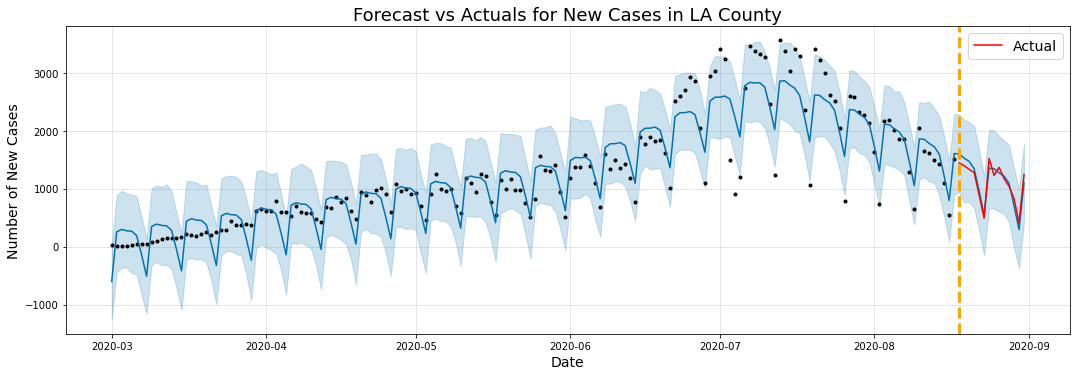

In [100]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_model.plot(forecast,ax=ax)
plt.plot(new_case_test['ds'],new_case_test['y'],'r',label='Actual')
plt.axvline(x=datetime.datetime(2020, 8, 18), color='orange', linestyle='--',lw=3)
plt.title('Forecast vs Actuals for New Cases in LA County',fontsize = 18)
plt.ylabel("Number of New Cases",fontsize=14)
plt.xlabel('Date',fontsize=14)
plt.legend(fontsize=14)
plt.show()

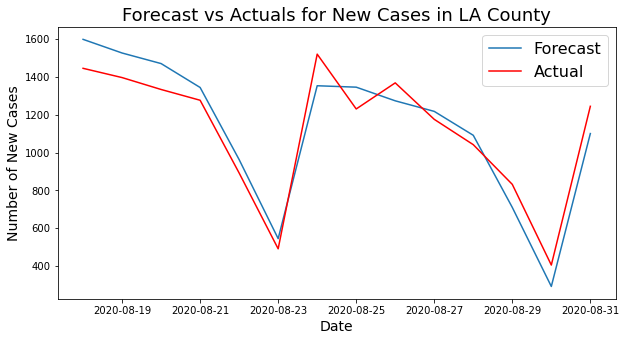

In [101]:
# during 08/18/20 - 08/31/20
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
fct = forecast[['ds','yhat']][-14:]
plt.plot(fct['ds'],fct['yhat'],label='Forecast')
plt.plot(new_case_test['ds'],new_case_test['y'],'r',label='Actual')
plt.title('Forecast vs Actuals for New Cases in LA County',fontsize=18)
plt.ylabel("Number of New Cases",fontsize=14)
plt.xlabel('Date',fontsize=14)
plt.legend(fontsize=16)
plt.show()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


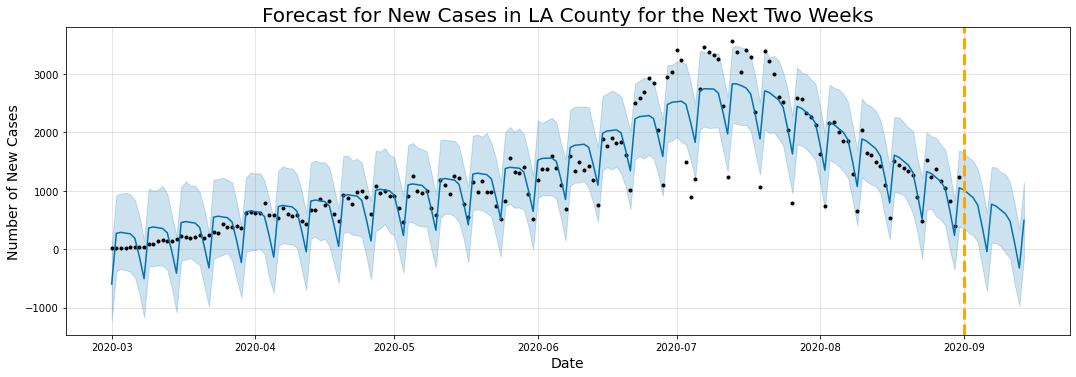

In [103]:
# predicting new case for the next two weeks
model = Prophet(changepoint_prior_scale= 0.15,
                      holidays_prior_scale = 0.4,
                      n_changepoints = 100,
                      seasonality_mode = 'additive',
                      weekly_seasonality=True,
                      interval_width=0.95)
input_data = df[['date','new_case']]
input_data.columns = ['ds', 'y']
model.fit(input_data)
future = model.make_future_dataframe(periods=14, freq='D')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(forecast,ax=ax)
plt.axvline(x=datetime.datetime(2020, 9, 1), color='orange', linestyle='--',lw=3)
plt.title('Forecast for New Cases in LA County for the Next Two Weeks',fontsize=20)
plt.ylabel("Number of New Cases",fontsize=14)
plt.xlabel('Date',fontsize=14)
plt.show()


In [104]:
# set last 14 days as test set, the rest as train set
# hospitalizations
split = df['date'] < '2020-08-18'
h_train = df[split][['date','hospitalizations']]
h_train.columns = ['ds', 'y']
h_test = df[-split][['date','hospitalizations']]
h_test.columns = ['ds', 'y']

# hyperparameters tuning 
params_grid_2 = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.05,0.1,0.15,0.175,0.2,0.25],
              'holidays_prior_scale':[0.2,0.25,0.3,0.35,0.4],
              'n_changepoints' : [50,75,100,125,150,200]
            }
grid_2 = ParameterGrid(params_grid_2)


parameters_2 = param(h_train, h_test, grid_2)
parameters_2.head()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

,MAE,RMSE,R_Square,Parameters
0,17.909289,22.584922,0.938565,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
1,17.909289,22.584922,0.938565,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
2,17.909289,22.584922,0.938565,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
3,17.909289,22.584922,0.938565,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
4,17.909289,22.584922,0.938565,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."


In [105]:
# best parameters with MAE = 18 and RMSE= 22.6
parameters_2['Parameters'][0]

{'changepoint_prior_scale': 0.1,
 'holidays_prior_scale': 0.3,
 'n_changepoints': 125,
 'seasonality_mode': 'multiplicative'}

In [106]:
final_model_2 = Prophet(
                      changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 0.3,
                      n_changepoints = 125,
                      seasonality_mode = 'multiplicative',
                      weekly_seasonality=True,
                      interval_width=0.95)

final_model_2.fit(h_train)
future_2 = final_model_2.make_future_dataframe(periods=14, freq='D')
forecast_2 = final_model_2.predict(future_2)
forecast_2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
179,2020-08-27,1085.419246,913.331382,1249.445357
180,2020-08-28,1038.746415,865.376824,1208.003604
181,2020-08-29,1030.116953,839.894714,1202.125979
182,2020-08-30,1026.784448,836.628052,1222.338141
183,2020-08-31,1004.930239,782.673499,1209.453504


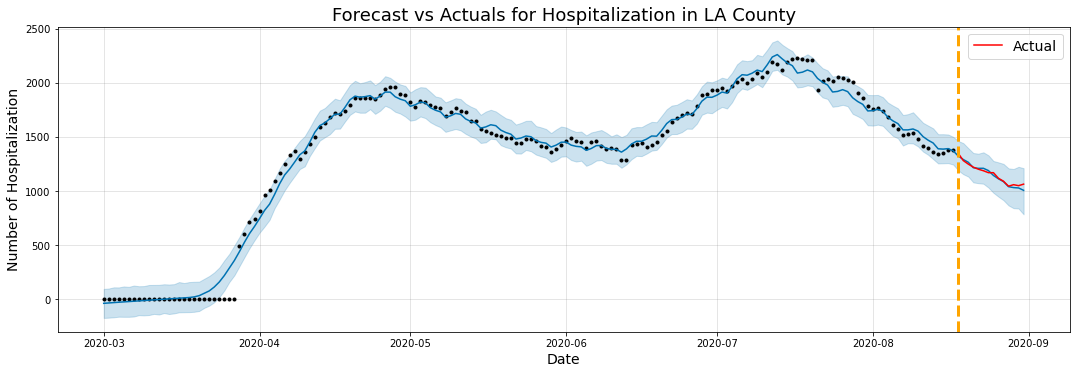

In [107]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_model_2.plot(forecast_2,ax=ax)
plt.plot(h_test['ds'],h_test['y'],'r',label='Actual')
plt.axvline(x=datetime.datetime(2020, 8, 18), color='orange', linestyle='--',lw=3)
plt.title('Forecast vs Actuals for Hospitalization in LA County',fontsize=18)
plt.ylabel("Number of Hospitalization",fontsize=14)
plt.xlabel('Date',fontsize=14)
plt.legend(fontsize=14)
plt.show()

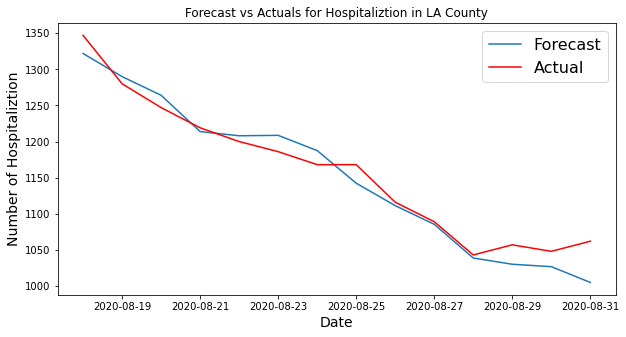

In [108]:
# during 08/18/20 - 08/31/20
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
fct_2 = forecast_2[['ds','yhat']][-14:]
plt.plot(fct_2['ds'],fct_2['yhat'],label='Forecast')
plt.plot(h_test['ds'],h_test['y'],'r',label='Actual')
plt.title('Forecast vs Actuals for Hospitaliztion in LA County')
plt.ylabel("Number of Hospitaliztion",fontsize=14)
plt.xlabel('Date',fontsize=14)
plt.legend(fontsize=16)
plt.show()

In [114]:
# predicting hospitalization for the next two weeks
model_2 = Prophet(changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 0.3,
                      n_changepoints = 125,
                      seasonality_mode = 'multiplicative',
                      weekly_seasonality=True,
                      interval_width=0.95)
input_data_2 = df[['date','hospitalizations']]
input_data_2.columns = ['ds', 'y']
model_2.fit(input_data_2)
future_2 = model_2.make_future_dataframe(periods=14, freq='D')
forecast_2 = model_2.predict(future_2)
forecast_2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
193,2020-09-10,685.664986,530.170439,832.603313
194,2020-09-11,645.466421,500.246435,803.863238
195,2020-09-12,629.001700,465.608170,784.399263
196,2020-09-13,615.129161,443.797404,796.247595
197,2020-09-14,590.475905,408.733933,773.861291


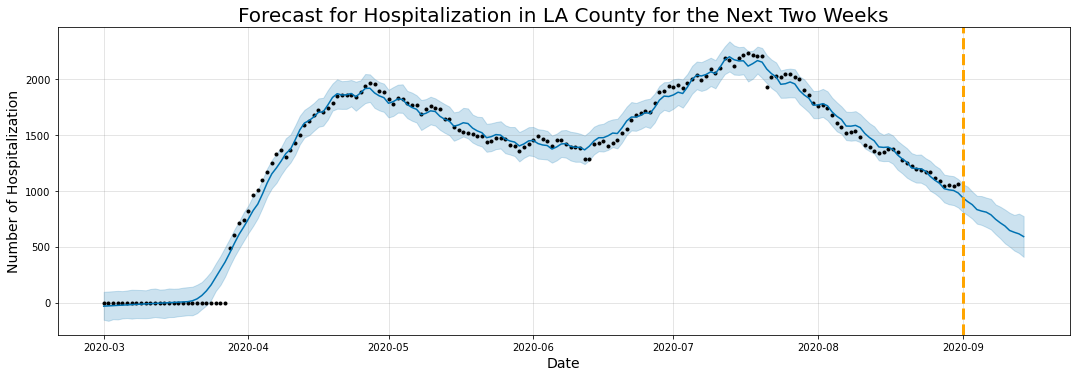

In [115]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model_2.plot(forecast_2,ax=ax)
plt.axvline(x=datetime.datetime(2020, 9, 1), color='orange', linestyle='--',lw=3)
plt.title('Forecast for Hospitalization in LA County for the Next Two Weeks',fontsize=20)
plt.ylabel("Number of Hospitalization",fontsize=14)
plt.xlabel('Date',fontsize=14)
plt.show()

In [116]:
idx = forecast['ds'] > '2020-08-15'

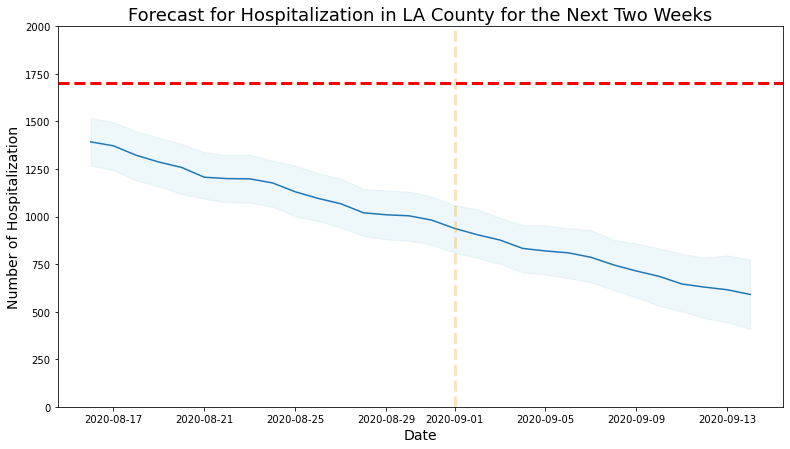

In [131]:
f, ax = plt.subplots(1)
f.set_figheight(7)
f.set_figwidth(13)
ds = forecast_2[idx]['ds']
yhat = forecast_2[idx]['yhat']
yhat_lower = forecast_2[idx]['yhat_lower']
yhat_upper = forecast_2[idx]['yhat_upper']
plt.plot(ds,yhat)
plt.fill_between(ds, yhat_lower, yhat_upper,
                 facecolor="orange", 
                 color='lightblue',       
                 alpha=0.2)     
plt.axvline(x=datetime.datetime(2020, 9, 1), color='orange', linestyle='--',lw=3,alpha=0.3)
plt.axhline(y=1700, color='red', linestyle='--',lw=3)
plt.title('Forecast for Hospitalization in LA County for the Next Two Weeks',fontsize=18)
plt.ylabel("Number of Hospitalization",fontsize=14)
plt.ylim(0,2000)
plt.xlabel('Date',fontsize=14)
plt.show()
